# Setup

In [1]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import datetime

import pandas as pd
from pandas import DataFrame,Series,read_table

General info

In [2]:
makePlots = True    # whether or not to save plots

saveAsPath = './Fig 01/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = 'PSG_example_'

In [3]:
birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['5 LEEGf-LEEGp', '6 LEEGm-LEEGp'],
                     ['5 LEEGf-LEEGm'], #, '4 LEEGf-Fgr'] this channel seems to have too much artifact
                     ['6LEEGm-LEEGp', '9REEGm-REEGp'],
                     ['9REEGf-REEGp', '6LEEGm-LEEGf'],
                     ['4LEEGf-LEEGp','7REEGf-REEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'


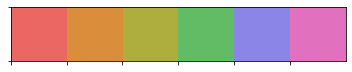

In [4]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

Plot-specific info

In [5]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))


Calculate general variables

In [6]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

## Read in files

### Load formatted scores

In [7]:
AllScores = {}
for b in range(nBirds):
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores[bird_name] = data

### loadData

In [8]:
def loadData(b):
    bird = 'Bird ' + str(b+1)

    EEGdataAll = {}

    arf_path = birdPaths[b] + arfFilePaths[b]

    # Load EEG channels
    for channel in channelsToLoadEEG[b]:
        all_data_array = np.array([])

        for file in np.sort(os.listdir(arf_path)):
            if file.endswith('.arf'):
                arffile = h5py.File(arf_path+file, 'r')
                data_array = arffile['.'][channel][()]
                data_array = np.ndarray.flatten(data_array)

                all_data_array = np.append(all_data_array,data_array)

        # Save in dict under bird number and channel
        data_name = 'Bird ' + str(b+1) + ': ' + channel
        EEGdataAll[data_name] = scalingFactor * all_data_array

    EEGchannels = np.sort(list(EEGdataAll.keys()))

    # Create time index for EEG

    all_time_array = np.array([], dtype='datetime64')
    for file in np.sort(os.listdir(arf_path)):
        if file.endswith('.arf'):
            arffile = h5py.File(arf_path+file, 'r')

            date = file.split('_')[2]

            if b == 0:
                hours = '17'
                minutes = '32'
            else:
                time = file.split('_')[3]
                hours = time.split('-')[0]
                minutes = time.split('-')[1]

            datetime_start = np.datetime64(date + 'T' + hours + ':' + minutes + ':06')    # assume 6-s delay in starting recording

            # time index in datetime format
            length_s = len(arffile['.'][channel][()])/sr
            length_ms = np.timedelta64(int(1000 * length_s), 'ms')
            datetime_end = datetime_start + length_ms

            time_array = np.arange(datetime_start, datetime_end, np.timedelta64(int(1000/sr),'ms')) 

            # Add to end of whole-night time index
            all_time_array = np.append(all_time_array, time_array)

    TimeIndexEEG = {}
    data_name = 'Bird ' + str(b+1)
    TimeIndexEEG[data_name] = all_time_array

    # Read in EOG traces

    EOGdataAll = {}

    arf_path = birdPaths[b] + arfFilePaths[b]

    for channel in channelsToLoadEOG[b]:
        all_data_array = np.array([])

        for file in np.sort(os.listdir(arf_path)):
            if file.endswith('.arf'):
                arffile = h5py.File(arf_path+file, 'r')
                data_array = arffile['.'][channel][()]
                data_array = np.ndarray.flatten(data_array)   

                all_data_array = np.append(all_data_array,data_array)

        # Save in dict under bird number and channel
        data_name = 'Bird ' + str(b+1) + ': ' + channel
        EOGdataAll[data_name] = scalingFactor * all_data_array


    EOGchannels = np.sort(list(EOGdataAll.keys()))
    
    return(bird, EEGdataAll, EEGchannels, TimeIndexEEG, EOGdataAll, EOGchannels)

## User-defined: which EEG channels to plot

In [9]:
AllEEGchannel_to_use = {}

In [10]:
# Bird 1

AllEEGchannel_to_use['Bird 1'] = ['Bird 1: 5 LEEGf-LEEGp',
                                  'Bird 1: 6 LEEGm-LEEGp', 
                                  'Bird 1: 8 REEGp-Fgr', ]

In [11]:
# Bird 2

AllEEGchannel_to_use['Bird 2'] = ['Bird 2: 4 LEEGf-Fgr',
                                  'Bird 2: 5 LEEGf-LEEGm']

In [12]:
# Bird 3

AllEEGchannel_to_use['Bird 3'] = ['Bird 3: 4LEEGf-LEEGp',
                                  'Bird 3: 6LEEGm-LEEGp', 
                                  'Bird 3: 9REEGm-REEGp', ]

In [13]:
# Bird 4

AllEEGchannel_to_use['Bird 4'] = ['Bird 4: 4LEEGf-LEEGp',
                                  'Bird 4: 5LEEGm-LEEGp',
                                  'Bird 4: 6LEEGm-LEEGf',
                                  'Bird 4: 7REEGf-Fgr',
                                  'Bird 4: 9REEGf-REEGp']   

In [14]:
# Bird 5

AllEEGchannel_to_use['Bird 5'] = ['Bird 5: 4LEEGf-LEEGp',
                                  'Bird 5: 6LEEGm-LEEGp', 
                                  'Bird 5: 7REEGf-REEGp', ]

# PlotFig1

In [15]:
def PlotFig1(b, startTime, EOGchannels, EEGchannels, dT=20, scoreBarWidth=10, ylimAmtEOG=250, yCalibBarEOG=200, xCalibBarEOG=1,
             ylimAmtEEG=150, yCalibBarEEG=100, xCalibBarEEG=1,
             sr=sr, colors=colors, stages=stages,
             linewidth=1, plotSizeMultiplier=1):

    '''Plot Figure 1: sleep score, EEG & EOG
    b = bird name
    startTime = where to start plotting, in seconds
    dT = number of seconds to plot
    ylimAmtEOG / EEG = set range of y axis above & below 0
    yCalibBarEOG / EEG = how big to make the calibration bar for uV
    xCalibBarEOG / EEG = how big to make the calibration bar for sec
    
    sr = sampling rate
    colors = list of colors to use for plotting sleep stages
    stages = list of sleep/wake stages
    EOGchannels = dictionary of EOG channels to use (for all birds)
    EEGchannels = dictionary of EEG channels to use (for all birds)

    '''
    
    stopTime = startTime + dT

    # Bird number from 0-4:
    birdID = int(b[5])-1
    
    # Get datetime index
    time_index = TimeIndexEEG[b]
    start_datetime_rec = time_index[0]
    
    # calc start and stop datetimes
    start_timedelta = startTime.astype('timedelta64[s]')
    dt_timedelta = np.timedelta64(dT, 's')
    
    start_datetime = start_datetime_rec + start_timedelta
    stop_datetime = start_datetime + dt_timedelta
    
    # Calculate start and stop in points
    dP = dT*sr
    startPts = np.where(time_index >= np.datetime64(start_datetime))[0][0]
    stopPts = np.where(time_index <= np.datetime64(stop_datetime))[0][-1]
    
    EOGtoPlot = [EOGchannels[x] for x in range(len(EOGchannels)) if b in EOGchannels[x]]
    EEGtoPlot = [EEGchannels[x] for x in range(len(EEGchannels)) if b in EEGchannels[x]]
    allChToPlot = np.concatenate((np.array(EOGtoPlot), np.array(EEGtoPlot)))
    nChToPlot = len(allChToPlot)

    plt.figure(figsize=(plotSizeMultiplier*.325*dT, (5/6)*nChToPlot+1))
    row = 1
    offset = 1/15    # fraction of plot size to leave blank on either side

    ###########################################################################

    # PLOT SLEEP SCORES AS BAR AT TOP
    plt.subplot(nChToPlot+1, 1, row)

    # Plotting parameters
    width = scoreBarWidth
    scoreLoc = 0

    # Get scores to plot
    bird_scores = AllScores[b]

    scoresToPlot = bird_scores[((bird_scores['Time (s)']+epochLength)>startTime)&(bird_scores['Time (s)']<=stopTime)]['Label'].values
    firstEpOffset = (startTime%epochLength)*sr # how much of first epoch is cut off at beginning, in pts
    nEpochs = len(scoresToPlot)
    
    # replace 'l' or 'g' in "Scores to Plot" with 'u' for unihem
    unihem_inds = [x for x in range(nEpochs) if ('l' in scoresToPlot[x])|('g' in scoresToPlot[x])]
    scoresToPlot[unihem_inds] = 'u'

    # 1. Plot first epoch (which might be cut off at beginning):

     # determine color based on sleep stage
    scoreNum = [x for x in range(len(stages)) if stages[x] in scoresToPlot[0]][0]
    scoreColor = colors[scoreNum]
     # determine where to draw the bar
    start = 0
    stop  = epochLengthPts - firstEpOffset
     # draw the bar
    plt.hlines(scoreLoc, start, stop, color=scoreColor, linewidth=width)

    # 2. Plot middle epochs
    for ep in np.arange(1,nEpochs-1):
         # determine color based on sleep stage
        scoreNum = [x for x in range(len(stages)) if stages[x] in scoresToPlot[ep]][0]
        scoreColor = colors[scoreNum]
         # determine where to draw the bar
        start = ep*epochLengthPts - firstEpOffset
        stop  = ep*epochLengthPts - firstEpOffset + epochLengthPts
         # draw the bar
        plt.hlines(scoreLoc, start, stop, color=scoreColor, linewidth=width)

    # 3. Plot last epoch (which might be cut off at end)
    lastEp = nEpochs-1
     # determine color based on sleep stage
    scoreNum = [x for x in range(len(stages)) if stages[x] in scoresToPlot[lastEp]][0]
    scoreColor = colors[scoreNum]
     # determine where to draw the bar
    start = lastEp*epochLengthPts - firstEpOffset
    stop  = dP
     # draw the bar
    plt.hlines(scoreLoc, start, stop, color=scoreColor, linewidth=width)

    # Get rid of axes
    plt.yticks([])
    plt.xticks([])
    sns.despine(left=True, bottom=True)

    plt.xlim(plt.xlim(-dP*offset, dP + dP*offset))
    row = row+1

    ###########################################################################

    # PLOT EOG CHANNELS

    # Set plot characteristics
    ylimAmt = ylimAmtEOG    # set range of y axis above & below 0
    yCalibBar = yCalibBarEOG  # how big to make the calibration bar for uV
    xCalibBar = xCalibBarEOG    # how big to make the calibration bar for sec
    eog_color = [142/255,134/255,137/255]

    for ch in EOGtoPlot:
        plt.subplot(nChToPlot+1, 1, row)

        # Plot!
        plt.plot(EOGdataAll[ch][startPts:stopPts], color=eog_color, lw=linewidth);

        # Set axis limits
        plt.ylim(-ylimAmt, ylimAmt)
        plt.xlim(-dP*offset, dP + dP*offset)
            # leave room on left side for labels
            # leave room on right side for calibration bars

        # Labels
        plt.ylabel(ch[len(ch)-8:len(ch)-4], rotation=0, fontsize=14, color=eog_color)


        # Get rid of axes
        plt.yticks([])
        plt.xticks([])
        sns.despine(left=True, bottom=True)

        row = row+1

    # Calibration bars
    plt.vlines(dP + dP*(offset/4), -yCalibBar - .75*yCalibBar, 0 - .75*yCalibBar);
    #plt.hlines(-yCalibBar - .75*yCalibBar, dP + dP*(offset/4) - xCalibBar*sr, dP + dP*(offset/4) );

    plt.text(1.01*(dP + dP*(offset/4)), -1.25*yCalibBar,    str(yCalibBar)+' uV', fontsize=10)
    #plt.text(dP - .5*xCalibBar*sr,     -2.75*yCalibBar,    str(xCalibBar)+' s', fontsize=10)

    ###########################################################################

    # PLOT EEG CHANNELS

    # Set plot characteristics
    ylimAmt = ylimAmtEEG    # set range of y axis above & below 0
    yCalibBar = yCalibBarEEG  # how big to make the calibration bar for uV
    xCalibBar = xCalibBarEEG    # how big to make the calibration bar for sec

    for ch in EEGtoPlot:
        plt.subplot(nChToPlot+1, 1, row)

        # Plot!
        plt.plot(EEGdataAll[ch][startPts:stopPts], color='k', lw=linewidth);

        # Set axis limits
        plt.ylim(-ylimAmt, ylimAmt)
        plt.xlim(-dP*offset, dP + dP*offset)
            # leave room on left side for labels
            # leave room on right side for calibration bars

        # Labels
        if 'LEEG' in ch:
            label_to_plot = 'LEEG'
        elif 'REEG' in ch:
            label_to_plot = 'REEG'
        plt.ylabel(label_to_plot, rotation=0, fontsize=14)


        # Get rid of axes
        plt.yticks([])
        plt.xticks([])
        sns.despine(left=True, bottom=True)

        row = row+1

    # Calibration bars
    plt.vlines(dP + dP*(offset/2), -yCalibBar - .75*yCalibBar, 0 - .75*yCalibBar);
    plt.hlines(-yCalibBar - .75*yCalibBar, dP + dP*(offset/2) - xCalibBar*sr, dP + dP*(offset/2) );

    plt.text(1.01*(dP + dP*(offset/2)), -0.6*yCalibBar,    str(yCalibBar)+' uV', fontsize=10)
    plt.text(dP - .75*xCalibBar*sr,     -1.7*yCalibBar,    str(xCalibBar)+' s', fontsize=10)

# Bird 1

In [16]:
bird = 'Bird 1'
b_num = int(bird[5]) - 1

bird, EEGdataAll, EEGchannels, TimeIndexEEG, EOGdataAll, EOGchannels = loadData(b_num)
EEGchannels_toUse = AllEEGchannel_to_use[bird]

## Drowsy & Wake 

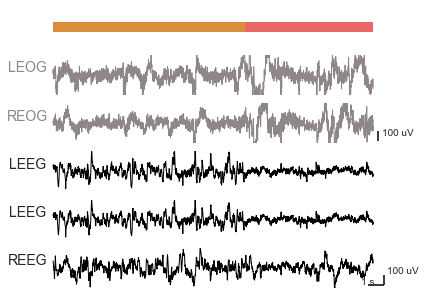

In [17]:
startTime = (np.timedelta64(0,'h') + np.timedelta64(0,'m') + np.timedelta64(4371,'s')).astype('int')
                               # hours                 minutes                seconds 
    
PlotFig1(bird, startTime, dT=20, ylimAmtEEG=200, yCalibBarEEG=100,
         ylimAmtEOG=200, yCalibBarEOG=100,
         EEGchannels=EEGchannels_toUse, EOGchannels=EOGchannels)

if makePlots:
    name = "Fig01b_drowsy_vsWake_" + bird + "_" + str(startTime) + "s"
    plt.savefig(saveAsPath + name + ".pdf")
    plt.savefig(saveAsPath + name + ".tiff")

## Unihemispheric sleep

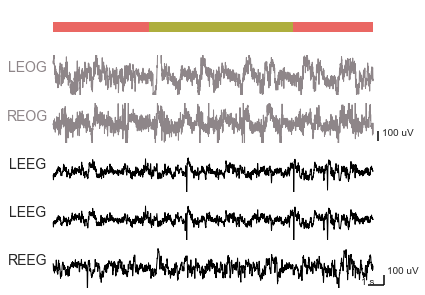

In [18]:
startTime = (np.timedelta64(0,'h') + np.timedelta64(0,'m') + np.timedelta64(1647,'s')).astype('int')
                               # hours                 minutes                seconds 
    
PlotFig1(bird, startTime, dT=20, ylimAmtEEG=200, yCalibBarEEG=100,
         ylimAmtEOG=200, yCalibBarEOG=100,
         EEGchannels=EEGchannels_toUse, EOGchannels=EOGchannels)

if makePlots:
    name = "Fig01c_unihem_" + bird + "_" + str(startTime) + "s"
    plt.savefig(saveAsPath + name + ".pdf")
    plt.savefig(saveAsPath + name + ".tiff")

## REM 

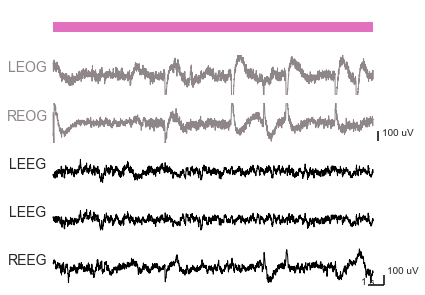

In [19]:
startTime = (np.timedelta64(0,'h') + np.timedelta64(0,'m') + np.timedelta64(23160,'s')).astype('int')
                               # hours                 minutes                seconds  
   
    
PlotFig1(bird, startTime, dT=20, ylimAmtEEG=200, yCalibBarEEG=100,
         ylimAmtEOG=200, yCalibBarEOG=100,
         EEGchannels=EEGchannels_toUse, EOGchannels=EOGchannels)

if makePlots:
    name = "Fig01d_REM_classic_" + bird + "_" + str(startTime) + "s"
    plt.savefig(saveAsPath + name + ".pdf")
    plt.savefig(saveAsPath + name + ".tiff")

## IS 

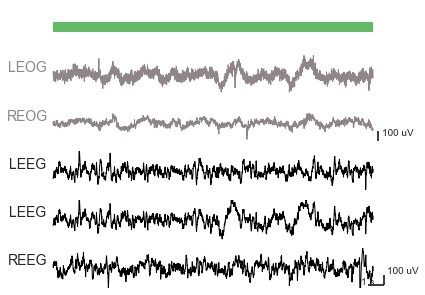

In [20]:
startTime = (np.timedelta64(0,'h') + np.timedelta64(0,'m') + np.timedelta64(23421,'s')).astype('int')
                               # hours                 minutes                seconds  
     
PlotFig1(bird, startTime, dT=20, ylimAmtEEG=200, yCalibBarEEG=100,
         ylimAmtEOG=200, yCalibBarEOG=100,
         EEGchannels=EEGchannels_toUse, EOGchannels=EOGchannels)

if makePlots:
    name = "Fig01e_IS_" + bird + "_" + str(startTime) + "s"
    plt.savefig(saveAsPath + name + ".pdf")
    plt.savefig(saveAsPath + name + ".tiff")

## SWS

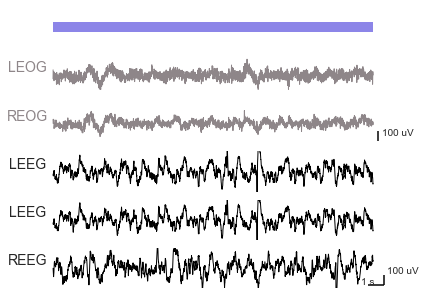

In [21]:
startTime = (np.timedelta64(0,'h') + np.timedelta64(0,'m') + np.timedelta64(18648,'s')).astype('int')
                               # hours                 minutes                seconds 
    
PlotFig1(bird, startTime, dT=20, ylimAmtEEG=200, yCalibBarEEG=100,
         ylimAmtEOG=200, yCalibBarEOG=100,
         EEGchannels=EEGchannels_toUse, EOGchannels=EOGchannels)

if makePlots:
    name = "Fig01f_SWS_" + bird + "_" + str(startTime) + "s"
    plt.savefig(saveAsPath + name + ".pdf")
    plt.savefig(saveAsPath + name + ".tiff")

## REM theta

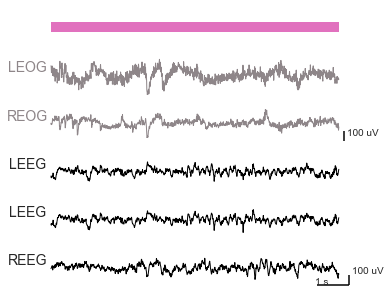

In [22]:
startTime = (np.timedelta64(0,'h') + np.timedelta64(0,'m') + np.timedelta64(16800,'s')).astype('int')
                               # hours                 minutes                seconds
   
# Double figure size to make this plot
PlotFig1(bird, startTime, dT=9, ylimAmtEEG=200, yCalibBarEEG=100,
         ylimAmtEOG=200, yCalibBarEOG=100,
         EEGchannels=EEGchannels_toUse, EOGchannels=EOGchannels,
        plotSizeMultiplier=2)

if makePlots:
    name = "Fig01g_REM_theta_" + bird + "_" + str(startTime) + "s"
    plt.savefig(saveAsPath + name + ".pdf")
    plt.savefig(saveAsPath + name + ".tiff")

# Bird 4

In [23]:
bird, EEGdataAll, EEGchannels, TimeIndexEEG, EOGdataAll, EOGchannels = loadData(3)
bird

'Bird 4'

In [24]:
# Bird 4

EEGchannels_toUse = ['Bird 4: 4LEEGf-LEEGp', 'Bird 4: 5LEEGm-LEEGp',
       'Bird 4: 6LEEGm-LEEGf', 'Bird 4: 7REEGf-Fgr', 'Bird 4: 9REEGf-REEGp']

In [25]:
bird = 'Bird 4'
b_num = int(bird[5]) - 1

bird, EEGdataAll, EEGchannels, TimeIndexEEG, EOGdataAll, EOGchannels = loadData(b_num)
EEGchannels_toUse = AllEEGchannel_to_use[bird]

## K complexes

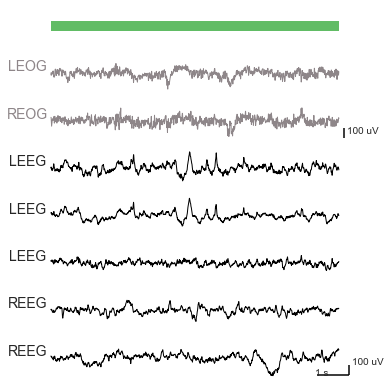

In [26]:
startTime = (np.timedelta64(0,'h') + np.timedelta64(0,'m') + np.timedelta64(32154,'s')).astype('int')
                               # hours                 minutes                seconds 
    
# Double figure size to make this plot
PlotFig1(bird, startTime, dT=9, ylimAmtEEG=200, yCalibBarEEG=100,
         ylimAmtEOG=200, yCalibBarEOG=100,
         EEGchannels=EEGchannels_toUse, EOGchannels=EOGchannels,
         plotSizeMultiplier=2)

if makePlots:
    name = "Fig01h_IS_Kcomplexes_" + bird + "_" + str(startTime) + "s"
    plt.savefig(saveAsPath + name + ".pdf")
    plt.savefig(saveAsPath + name + ".tiff")

## SWS vs IS

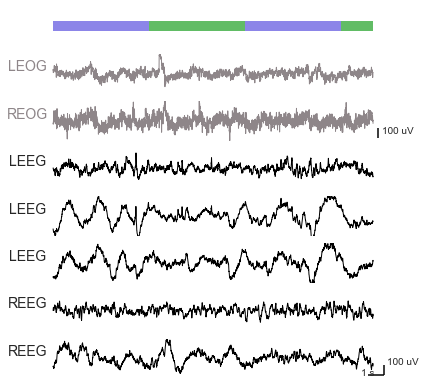

In [27]:
startTime = (np.timedelta64(0,'h') + np.timedelta64(0,'m') + np.timedelta64(22431,'s')).astype('int')
                               # hours                 minutes                seconds 
    
PlotFig1(bird, startTime, dT=20, ylimAmtEEG=200, yCalibBarEEG=100,
         ylimAmtEOG=200, yCalibBarEOG=100,
         EEGchannels=EEGchannels_toUse, EOGchannels=EOGchannels)

if makePlots:
    name = "Fig01i_SWS_toIS_quickly_" + bird + "_" + str(startTime) + "s"
    plt.savefig(saveAsPath + name + ".pdf")
    plt.savefig(saveAsPath + name + ".tiff")